<a href="https://colab.research.google.com/github/pragy10/ML_projects/blob/main/unfinished_exoplanets_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Importing the dataset

In [ ]:
train = pd.read_csv(r'/kaggle/input/kepler-labelled-time-series-data/exoTrain.csv')
test = pd.read_csv(r'/kaggle/input/kepler-labelled-time-series-data/exoTest.csv')
print(train.head())

   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      48.57      92.54      39.32      61.42       5.08  

In [ ]:
print(test.head())

   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6   FLUX.7  \
0      2   119.88   100.21    86.46    48.68    46.12    39.39    18.57   
1      2  5736.59  5699.98  5717.16  5692.73  5663.83  5631.16  5626.39   
2      2   844.48   817.49   770.07   675.01   605.52   499.45   440.77   
3      2  -826.00  -827.31  -846.12  -836.03  -745.50  -784.69  -791.22   
4      2   -39.57   -15.88    -9.16    -6.37   -16.13   -24.05    -0.90   

    FLUX.8   FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0     6.98     6.63  ...      14.52      19.29      14.44      -1.62   
1  5569.47  5550.44  ...    -581.91    -984.09   -1230.89   -1600.45   
2   362.95   207.27  ...      17.82     -51.66     -48.29     -59.99   
3  -746.50  -709.53  ...     122.34      93.03      93.03      68.81   
4   -45.20    -5.04  ...     -37.87     -61.85     -27.15     -21.18   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      13.33      45.50      31.93      35.78 

# Checking number of non-exo and exo planets

In [ ]:
grouped = train['LABEL'].value_counts()
grouped

LABEL
1    5050
2      37
Name: count, dtype: int64

# Changing labels for ease

In [ ]:
change = {2:1,1:0}
train['LABEL'] = [change[i] for i in train['LABEL']]
test['LABEL'] = [change[i] for i in test['LABEL']]

In [ ]:
new_grouped = train['LABEL'].value_counts()
new_grouped

LABEL
0    5050
1      37
Name: count, dtype: int64

# EDA

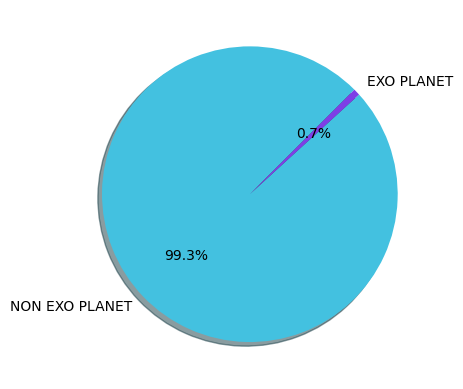

In [ ]:
plt.pie(new_grouped,colors = ['#43c1e0','#7e3ee6'],labels=['NON EXO PLANET','EXO PLANET'],shadow=True,autopct='%1.1f%%',textprops={'color':'black'},startangle=45)
plt.show()

# Investigating Flux patterns in Exo planets and Non Exo planets

In [ ]:
train_exo = train[train['LABEL']==1]
train_non = train[train['LABEL']==0]
train_exo_new = train_exo.iloc[:,1:].T
train_non_new = train_non.iloc[:,1:].T

print(train_exo_new.head())


           0      1       2       3        4       5      6       7       8   \
FLUX.1  93.85 -38.88  532.64  326.52 -1107.21  211.10   9.34  238.77 -103.54   
FLUX.2  83.81 -33.83  535.92  347.39 -1112.59  163.57  49.96  262.16 -118.97   
FLUX.3  20.10 -58.54  513.73  302.35 -1118.95  179.16  33.30  277.80 -108.93   
FLUX.4 -26.98 -40.09  496.92  298.13 -1095.10  187.82   9.63  190.16  -72.25   
FLUX.5 -39.56 -79.31  456.45  317.74 -1057.55  188.46  37.64  180.98  -61.46   

            9   ...      27     28     29      30      31     32     33  \
FLUX.1 -265.91  ...  124.39 -63.50  31.29 -472.50  194.82  26.96  43.07   
FLUX.2 -318.59  ...   72.73 -49.15  25.14 -384.09  162.51  38.98  46.73   
FLUX.3 -335.66  ...   36.85 -45.99  36.93 -330.42  126.17  25.99  29.43   
FLUX.4 -450.47  ...   -4.68 -34.55  16.63 -273.41  129.70  47.28   9.75   
FLUX.5 -453.09  ...    6.96 -44.34  17.01 -185.02   82.27  26.29   6.54   

            34     35     36  
FLUX.1 -248.23  22.82  26.24  
FLUX.2

### We can analyze the existance of an exo planet based on the periodicity in flux variations of an observed star. For analysis, the flux is plotted against time. if there is some degree of periodicity in the flux patterns, then we can confirm that there is an exo planet, else there's no exo planet

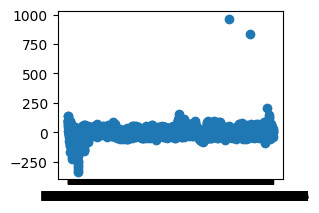

In [ ]:
plt.subplot(2,2,1)
plt.scatter(x=train_non_new.iloc[:,2].index,y=train_non_new.iloc[:,2])
plt.show()

In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Flux variation of star 37", "Flux variation of star 5086", "Flux variation of star 3000", "Flux variation of star 3001"))
fig.add_trace(go.Scatter(y=train_non_new[37], x=train_non_new.index),row=1, col=1)
fig.add_trace(go.Scatter(y=train_non_new[5086], x=train_non_new.index),row=1, col=2)
fig.add_trace(go.Scatter(y=train_non_new[3000], x=train_non_new.index),row=2, col=1)
fig.add_trace(go.Scatter(y=train_non_new[3001], x=train_non_new.index),row=2, col=2)
fig.update_layout(height=600, width=800, title_text="Non Exoplanets Star examples",showlegend=False)
fig.show()

In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Flux variation of star 27", "Flux variation of star 13", "Flux variation of star 5", "Flux variation of star 33"))
fig.add_trace(go.Scatter(y=train_exo_new[27], x=train_exo_new.index),row=1, col=1)
fig.add_trace(go.Scatter(y=train_exo_new[13], x=train_exo_new.index),row=1, col=2)
fig.add_trace(go.Scatter(y=train_exo_new[5], x=train_exo_new.index),row=2, col=1)
fig.add_trace(go.Scatter(y=train_exo_new[33], x=train_exo_new.index),row=2, col=2)
fig.update_layout(height=600, width=800, title_text="Exoplanets Star examples",showlegend=False)
fig.show()

# Normalizing the Data

In [ ]:
trainx = train.iloc[:,1:]
testx = test.iloc[:,1:]
scaler = StandardScaler()
train_scaled = scaler.fit_transform(trainx)
test_scaled = scaler.fit_transform(testx)

# Reducing data variation using PCA

In [ ]:
trainy = train['LABEL']
testy = test['LABEL']

num_components = [2,3,4,5,6,7,8]
scores = []

for n in num_components:
    pca = PCA(n_components=n)
    x_pca = pca.fit_transform(train_scaled)
    model = LogisticRegression()
    score = np.mean(cross_val_score(model,x_pca,trainy,cv=5))
    scores.append(score)

print(scores)

[0.9923334743544421, 0.9923334743544421, 0.9917438902121691, 0.9917438902121691, 0.9915474265579451, 0.9913509629037212, 0.9907611855818473]


In [ ]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(train_scaled)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
trns_x=pca.transform(train_scaled)
trns_y=pca.transform(test_scaled)

[0.27373539 0.22536219 0.14929127]
[2109.92811427 1914.4441909  1558.18634093]


In [ ]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(trns_x,trainy)
prediction = svm_classifier.predict(trns_y)
print(classification_report(testy,prediction))

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



# Balancing classes with SMOTE